In [12]:
import sys
from sys import platform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
from matplotlib.gridspec import GridSpec
import copy
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

import numpy as np
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.integrate import quad
from IPython.display import display, Math
from scipy.interpolate import CubicSpline
from tqdm import tqdm

import pickle

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import functional_models, fitting
from astropy.timeseries import LombScargle

import stingray.events as ev
import stingray.lightcurve as lc
from stingray import io
import stingray.powerspectrum as powspec 
import stingray.crossspectrum as crossspec
from stingray.pulse.search import phaseogram, plot_phaseogram, plot_profile, epoch_folding_search, z_n_search
from stingray.pulse.pulsar import fold_events, pulse_phase
import stingray.gti as sting_gti
import stingray.pulse.accelsearch as accelsearch
from stingray import stats
from stingray.deadtime import fad


sns.set_context('paper')
sns.set(font_scale=1.6)
sns.set_style("whitegrid")
sns.set_style({'axes.edgecolor': 'black', 'xtick.bottom': True, 'ytick.left': True,})
sns.set_palette("colorblind")

sys.path.insert(1, '/Users/sean/scripts/helpers')

from stingray_plus import *

root_dir = '/Users/sean/astro/MAXI_J0655m013/'

def gaussian(x,A,mu,sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

def power_law(x, A, gamma):
    return A*np.power(x, -gamma)

def lorentz(x, A, mu, gamma):
    return A*(1./gamma)*(gamma**2)/(((x-mu)**2) + (gamma**2))

def power_law_lorentz(x, A, B, mu, gamma):
    return (power_law(x, A) + lorentz(x, B, mu, gamma))

def power_law_lorentz_lorentz(x, A, B, mu, gamma, C, mu2, gamma2, plgamma):
    return (power_law(x, A, plgamma) + lorentz(x, B, mu, gamma) + lorentz(x, C, mu2, gamma2))



In [2]:
OBSID='80801347002'

products_dir = root_dir + OBSID + '_products06/'
pipeline_dir = root_dir + OBSID + '_pipe_out/'
plot_dir = root_dir + 'figures/'
chu_combos = ['12','23','13', '123', '1', '2']

nu =  0.0008856113733277114

# Light-curve

In [3]:
src_lc_A = fits.open(products_dir + 'nu80801347002A06_sr.lc')[1].data
bkg_lc_A = fits.open(products_dir + 'nu80801347002A06_bk.lc')[1].data
src_lc_B = fits.open(products_dir + 'nu80801347002B06_sr.lc')[1].data
bkg_lc_B = fits.open(products_dir + 'nu80801347002B06_bk.lc')[1].data

same_time_B = [t in src_lc_A['TIME'] for t in src_lc_B['TIME']]
same_time_A = [t in src_lc_B['TIME'] for t in src_lc_A['TIME']]

1.0010977983474731


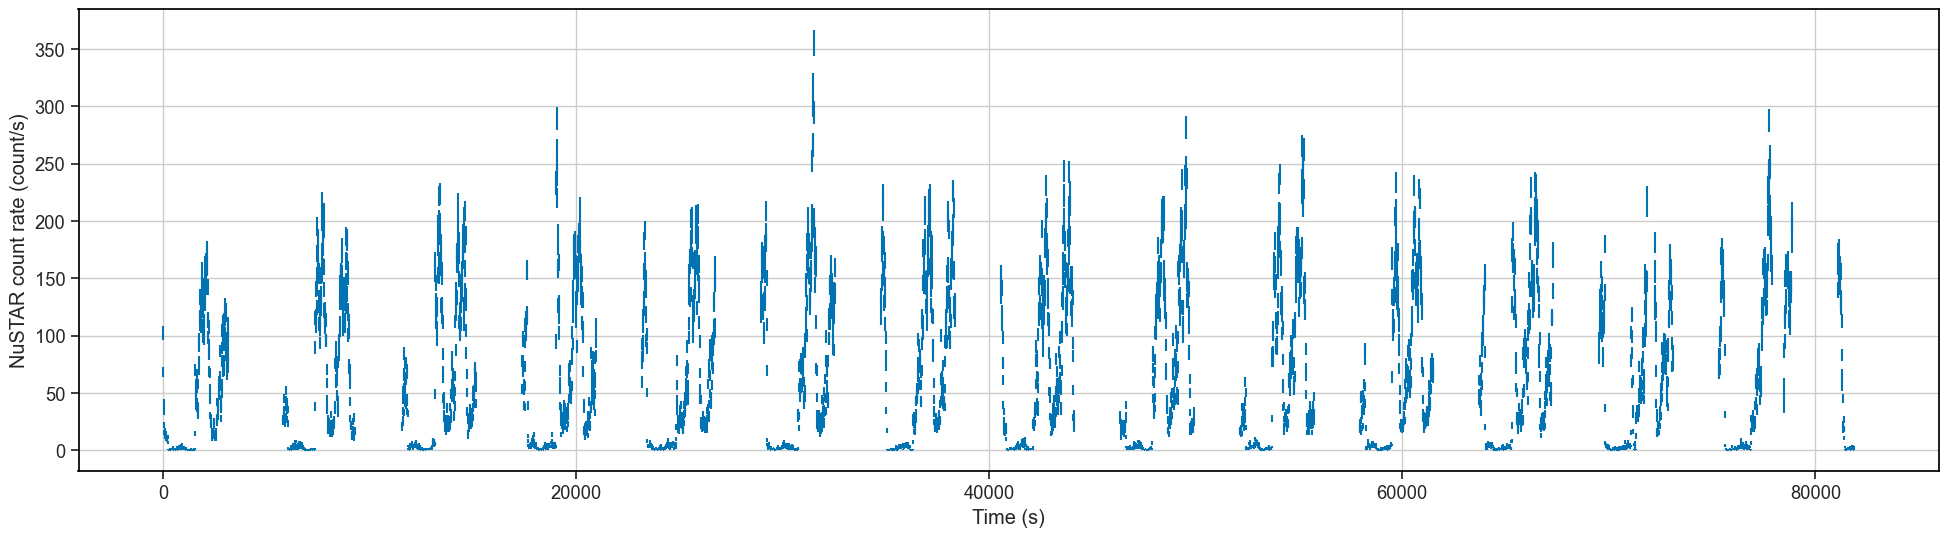

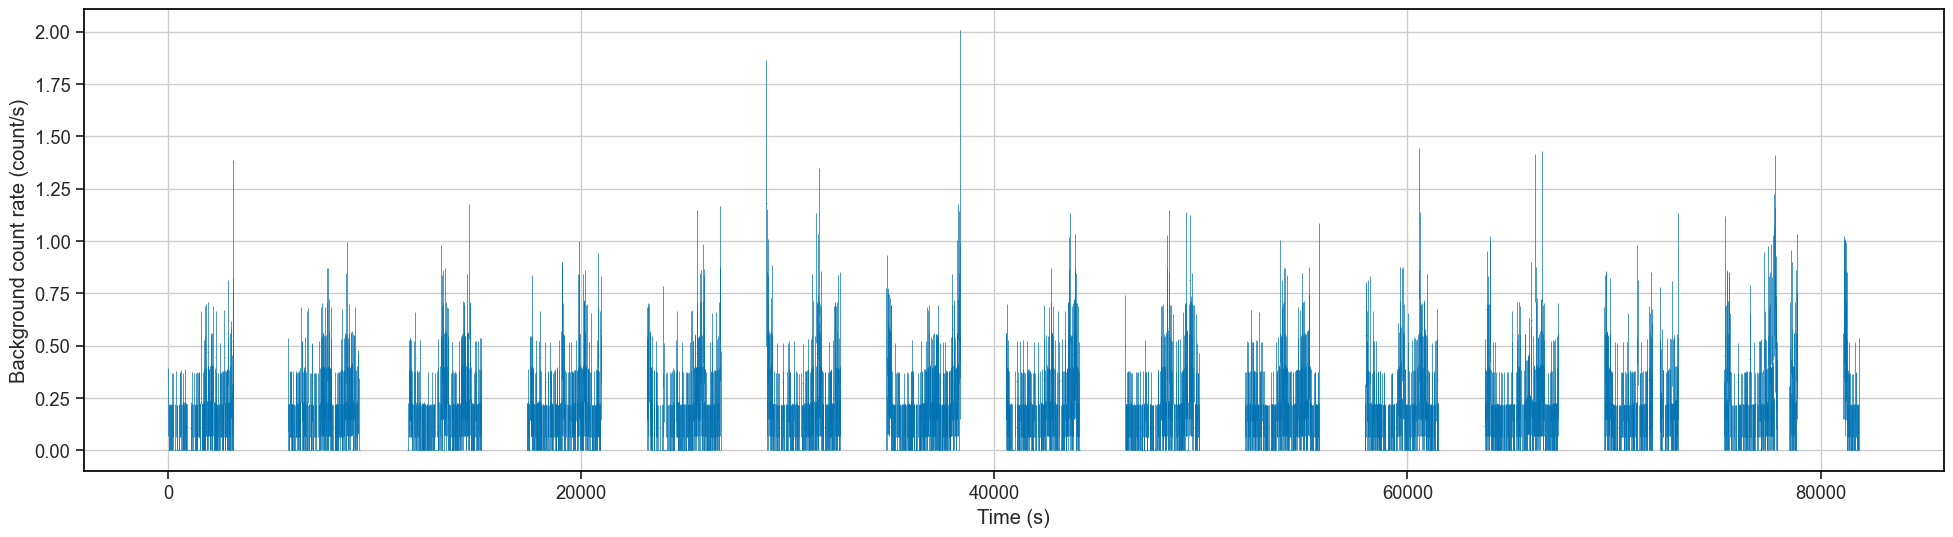

In [4]:
area_ratio = np.square(2./3.)
source_rms_factor = ((((np.mean(bkg_lc_A['RATE']*area_ratio) + np.mean(src_lc_A['RATE']))/np.mean(src_lc_A['RATE'])) + ((np.mean(bkg_lc_B['RATE']*area_ratio) + np.mean(src_lc_B['RATE']))/np.mean(src_lc_B['RATE'])))/2.)
print(source_rms_factor)
plt.figure(figsize = (24, 6))
plt.errorbar(src_lc_A['TIME'][same_time_A], (src_lc_A['RATE'][same_time_A] + src_lc_B['RATE'][same_time_B])-(area_ratio*(np.mean(bkg_lc_A['RATE']) + np.mean(bkg_lc_B['RATE']))), xerr=5, yerr=np.sqrt(np.square(src_lc_A['ERROR'][same_time_A]) + np.square(src_lc_B['ERROR'][same_time_B])), ls='')

plt.ylabel('NuSTAR count rate (count/s)')
plt.xlabel('Time (s)')

plt.savefig(plot_dir + OBSID + '_lc_fpma+fpmb.pdf')

plt.figure(figsize = (24, 6))
plt.errorbar(bkg_lc_A['TIME'][same_time_A], (bkg_lc_A['RATE'][same_time_A] + bkg_lc_B['RATE'][same_time_B]), xerr=5, yerr=np.sqrt(np.square(bkg_lc_A['ERROR'][same_time_A]) + np.square(bkg_lc_B['ERROR'][same_time_B])), ls='', lw=0.5)

plt.ylabel('Background count rate (count/s)')
plt.xlabel('Time (s)')

plt.savefig(plot_dir + OBSID + '_lc_fpma+fpmb_bkg.pdf')


chu12
chu23
chu13
chu123
chu1
chu2
chu12
chu23
chu13
chu123
chu1
chu2
chu12
chu23
chu13
chu123
chu1
chu2


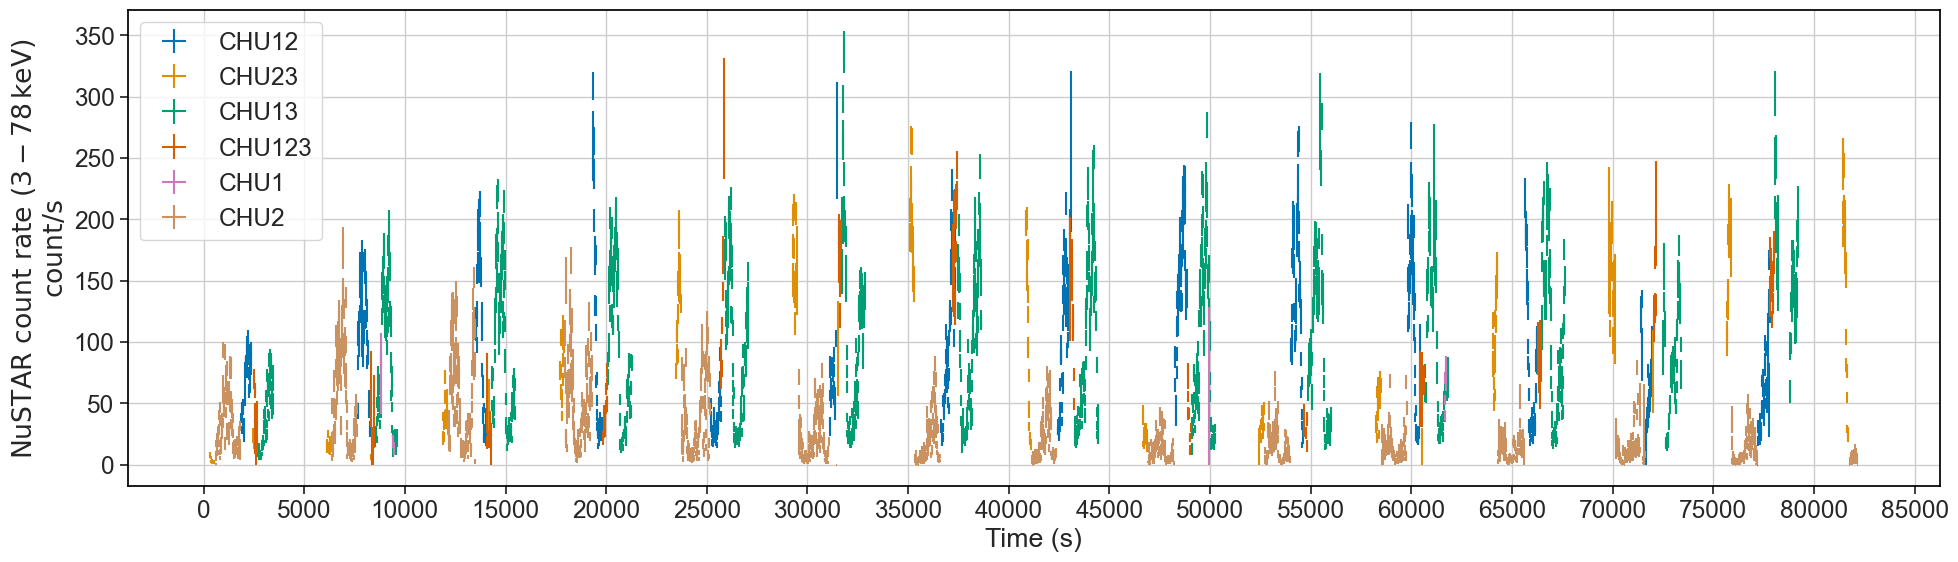

In [13]:
PI_min = eV_to_PI(3000)     # 3.0 keV
PI_max = eV_to_PI(78000)   # 78.0 keV

TSTART = 3.935466220000000E+08

for fpm in ['A', 'B']:
    plt.figure(figsize=(20,6))
    lcurve_ax = plt.gca()
    for chu in chu_combos:
        print('chu' + chu)

        src_lc = nuproducts_to_stingray_lc(root_dir + OBSID + '_products06/nu'+OBSID+fpm + '06_chu' + chu + '_S_sr.lc')
        bkg_lc = nuproducts_to_stingray_lc(root_dir + OBSID + '_products06/nu'+OBSID+fpm + '06_chu' + chu + '_S_bk.lc')

        area_ratio = np.square(src_lc.radius/bkg_lc.radius)

        lcurve_ax.errorbar(src_lc.time-TSTART, src_lc.countrate-(bkg_lc.meanrate*area_ratio), xerr=src_lc.dt/2, yerr=src_lc.countrate_err, ls='', label = 'CHU'+str(chu))


    lcurve_ax.set_xlabel('Time (s)')
    lcurve_ax.set_ylabel('FPM' + fpm + r'$\ \mathrm{\ count\ rate\ (3-78\,keV)}$')
    lcurve_ax.legend()
    plt.tight_layout()
    plt.savefig(plot_dir + OBSID + '_lc_chusplit_FPM' + fpm + '.pdf')
    plt.close()
    
plt.figure(figsize=(20,6))
lcurve_ax = plt.gca()
for chu in chu_combos:
    print('chu' + chu)

    chu_start = fits.open(products_dir + 'nu80801347002A06_chu' + chu + '_S_sr.lc')[0].header['TSTART'] - TSTART
    src_lc_A = fits.open(products_dir + 'nu80801347002A06_chu' + chu + '_S_sr.lc')[1].data
    bkg_lc_A = fits.open(products_dir + 'nu80801347002A06_chu' + chu + '_S_bk.lc')[1].data
    src_lc_B = fits.open(products_dir + 'nu80801347002B06_chu' + chu + '_S_sr.lc')[1].data
    bkg_lc_B = fits.open(products_dir + 'nu80801347002B06_chu' + chu + '_S_bk.lc')[1].data
    same_time_B = [t in src_lc_A['TIME'] for t in src_lc_B['TIME']]
    same_time_A = [t in src_lc_B['TIME'] for t in src_lc_A['TIME']]
    lcurve_ax.errorbar(src_lc_A['TIME'][same_time_A] + chu_start, (src_lc_A['RATE'][same_time_A] + src_lc_B['RATE'][same_time_B])-(area_ratio*(np.mean(bkg_lc_A['RATE']) + np.mean(bkg_lc_B['RATE']))), \
                       xerr=5, yerr=np.sqrt(np.square(src_lc_A['ERROR'][same_time_A]) + np.square(src_lc_B['ERROR'][same_time_B])), ls='', label = 'CHU'+str(chu))


lcurve_ax.set_xlabel('Time (s)')
lcurve_ax.set_ylabel(r'$\mathrm{NuSTAR\ count\ rate\ (3-78\,keV)}$' + '\n' + r'$\mathrm{count/s}$')
lcurve_ax.set_xticks(np.arange(18)*5000)
# lcurve_ax.set_xticks(np.arange(18)*5000)
lcurve_ax.legend()
plt.tight_layout()
plt.savefig(plot_dir + OBSID + '_lc_chusplit_fpma+fpmb.pdf')
# plt.close()

# Calculate the FAD and Z_n search

In [14]:
events = extract_events(pipeline_dir + 'nu' + OBSID + 'A06_cl_bc_srcreg_3-78keV.evt', pipeline_dir + 'nu' + OBSID + 'B06_cl_bc_srcreg_3-78keV.evt')
all_times = np.sort(np.concatenate([events[0].time, events[1].time]))
half_times_1 = all_times[:int(len(all_times)/2)]
half_times_2 = all_times[-int(len(all_times)/2):]
# half_times_3 = all_times[-int(len(all_times)/3):]
print(np.min(all_times))
print(np.min(half_times_1))
print(np.min(half_times_2))
# print(np.min(half_times_3))
print(np.mean(half_times_1)-np.mean(half_times_2))

393546490.9914229
393546490.9914229
393588976.69715333
-38318.99343442917


In [15]:
# fad_pds = fad.FAD(events[0], events[1], segment_size=3400, dt=1.0/2048., norm='frac', return_objects=True)['ptot']
# pickle.dump(fad_pds, open(pipeline_dir + 'FAD_ptot_rms.txt', 'wb'))
fad_pds = pickle.load(open(pipeline_dir + 'FAD_ptot_rms.txt', 'rb'))
print(fad_pds.freq[:5])

0.00048828125


In [16]:
source_norm= False
if not source_norm:
    fad_pds.power = fad_pds.power*source_rms_factor*source_rms_factor
    source_norm=True
if fad_pds.norm == 'frac':
    fad_pds.power_err = fad_pds.power/np.sqrt(fad_pds.m)
elif fad_pds.norm == 'leahy':
    fad_pds.power_err = fad_pds.power/np.sqrt(fad_pds.m/2.)
# pickle.dump(fad_pds, open(pipeline_dir + 'FAD_ptot_Leahy.txt', 'wb'))
# print(fad_pds.df/2)
# print(fad_pds.freq)
log_pds = fad_pds.rebin_log(f=0.005)
if fad_pds.norm =='leahy':
    p_noise = 2.0
else:
    p_noise = np.mean(fad_pds.power[fad_pds.freq>10.])
print(p_noise)

0.11969894405965624


nu0 = 0.08869046214121674 +/- 0.0007619199854493341
gamma0 = 0.009583230883416614 +/- 0.0012645433631472472
Q0 = 4.627377928183487+/- 0.6118925967169319
rms0 = 0.13353534449044505 +/- 0.006875211480555701
nu1 = 0.17867608717841424 +/- 0.006149624707281211
gamma1 = 0.07756944416720876 +/- 0.01218555023638877
Q1 = 1.1517169492233301+/- 0.1852171466793723
rms1 = 0.18502097605605072 +/- 0.01311522713389401
pl_gamma = 1.9836374686696583 +/- 0.2613910153719419


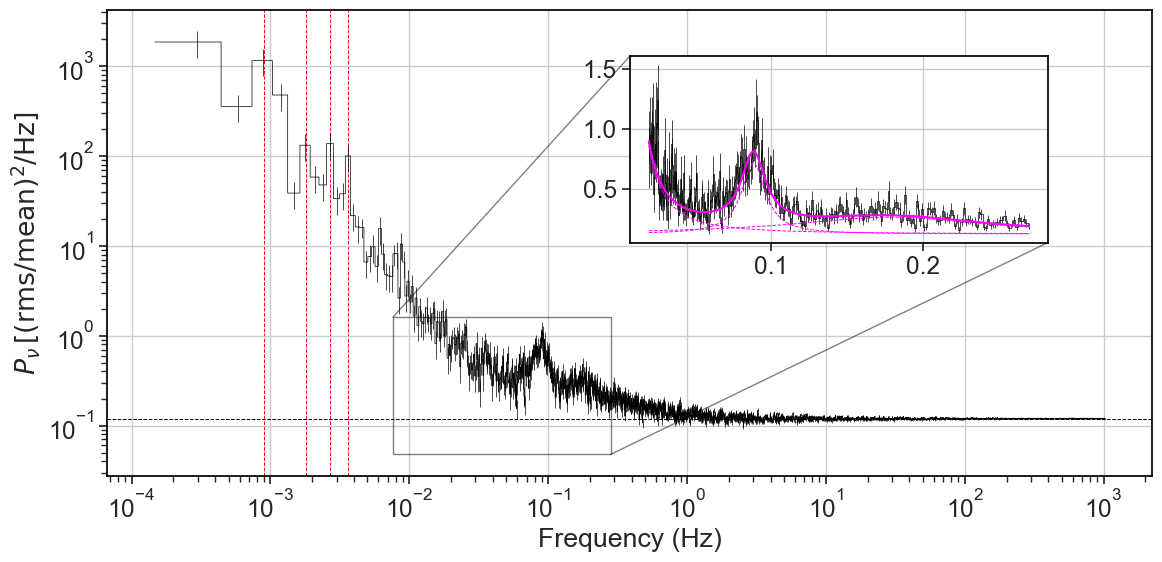

In [17]:
# plot_mask = fad_pds['freq'] < 10
# z_search_result = 0.0008853307364883761
z_search_result=0.0009
plt.figure(figsize=(12,6))
# plt.errorbar(fad_pds.freq, fad_pds.power, yerr=fad_pds.power_err, \
#                      fmt='none', color='black', lw=0.5, rasterized=True)
# plt.step(fad_pds.freq, fad_pds.power, where='mid', color='black', lw=0.5, rasterized=True)

plt.errorbar(log_pds.freq, log_pds.power, yerr=log_pds.power_err, \
                     fmt='none', color='black', lw=0.5, rasterized=False)
plt.step(np.concatenate([[log_pds.freq[0]-log_pds.df/2.], log_pds.freq]), np.concatenate([[log_pds.power[0]], log_pds.power]), where='mid', color='black', lw=0.5, rasterized=False)

plt.axhline(p_noise, color='black', ls='--', lw=0.7)

for i in range(4):
    plt.axvline(z_search_result * (i+1), color='red', ls='--', lw=0.7, zorder=0)
    
plt.loglog()
plt.xlabel('Frequency (Hz)')

outer_ax = plt.gca()
inset = outer_ax.inset_axes([0.5, 0.5, 0.4, 0.4])
fit_mask = (log_pds.freq > 0.02) * (log_pds.freq < 0.27)
inset.errorbar(log_pds.freq[fit_mask], log_pds.power[fit_mask], yerr=log_pds.power_err[fit_mask], \
                     fmt='none', color='black', lw=0.5, rasterized=False)
inset.step(log_pds.freq[fit_mask], log_pds.power[fit_mask], where='mid', color='black', lw=0.5, rasterized=False)
outer_ax.indicate_inset_zoom(inset, edgecolor="black")

# popt, pcov = curve_fit(power_law_lorentz, log_pds.freq[fit_mask], log_pds.power[fit_mask]-2.,p0=[0.01, 20, 0.09, 0.1], sigma=log_pds.power_err[fit_mask])
# print(popt)
# print(np.sqrt(np.diag(pcov)))
# # plt.loglog()
# inset.plot(log_pds.freq[fit_mask], power_law_lorentz(log_pds.freq[fit_mask], *popt) + 2., color='cyan')

popt, pcov = curve_fit(power_law_lorentz_lorentz, log_pds.freq[fit_mask], log_pds.power[fit_mask]-p_noise,p0=[0.1, 1.0, 0.09, 0.01, 0.1, 0.18, 0.1, 2.0], sigma=log_pds.power_err[fit_mask])
# print(popt)
# print(np.sqrt(np.diag(pcov)))
# plt.loglog()
inset.plot(log_pds.freq[fit_mask], power_law_lorentz_lorentz(log_pds.freq[fit_mask], *popt)+ p_noise, color='magenta')
inset.plot(log_pds.freq[fit_mask], power_law(log_pds.freq[fit_mask], *[popt[0], popt[-1]]) + p_noise, color='magenta', ls='--', lw=0.7)
inset.plot(log_pds.freq[fit_mask], lorentz(log_pds.freq[fit_mask], *popt[1:4]) + p_noise, color='magenta', ls='--', lw=0.7)
inset.plot(log_pds.freq[fit_mask], lorentz(log_pds.freq[fit_mask], *popt[4:-1]) + p_noise, color='magenta', ls='--', lw=0.7)

# inset.set_yscale('log')

if fad_pds.norm =='leahy':
    plt.ylabel('Leahy Power')
else:
    plt.ylabel(r'$P_{\nu}\,[\mathrm{(rms/mean)^{2}/Hz}]$')
    print('nu0 = ' + str(popt[2]) + ' +/- ' + str(np.sqrt(np.diag(pcov)[2])))
    print('gamma0 = ' + str(popt[3]) + ' +/- ' + str(np.sqrt(np.diag(pcov))[3]))
    print('Q0 = ' + str(popt[2]/(2.*popt[3])) + '+/- ' +  str((popt[2]/(2.*popt[3]))*np.sqrt((np.diag(pcov)[2]/np.square(popt[2])) + (np.diag(pcov)[3]/np.square(popt[3])))))
    print('rms0 = ' + str(np.sqrt(np.pi*popt[1])) + ' +/- ' + str(np.sqrt(np.pi*np.diag(pcov)[1]/popt[1])/2.))
    print('nu1 = ' + str(popt[2+3]) + ' +/- ' + str(np.sqrt(np.diag(pcov)[2+3])))
    print('gamma1 = ' + str(popt[3+3]) + ' +/- ' + str(np.sqrt(np.diag(pcov))[3+3]))
    print('Q1 = ' + str(popt[2+3]/(2.*popt[3+3])) + '+/- ' +  str((popt[2+3]/(2.*popt[3+3]))*np.sqrt((np.diag(pcov)[2+3]/np.square(popt[2+3])) + (np.diag(pcov)[3+3]/np.square(popt[3+3])))))
    print('rms1 = ' + str(np.sqrt(np.pi*popt[1+3])) + ' +/- ' + str(np.sqrt(np.pi*np.diag(pcov)[1+3]/popt[1+3])/2.))

    print('pl_gamma = ' + str(popt[-1]) + ' +/- ' + str(np.sqrt(np.diag(pcov)[-1])))
    


plt.tight_layout()
# plt.savefig(plot_dir + OBSID + '_FAD_ptot_rms.pdf')

[0.00000000e+00 1.91195590e-07 3.82391180e-07 ... 1.91138231e-03
 1.91157351e-03 1.91176471e-03]
[0.00000000e+00 1.91195590e-07 3.82391180e-07 ... 1.91138231e-03
 1.91157351e-03 1.91176471e-03]
[0.00000000e+00 1.91195590e-07 3.82391180e-07 ... 1.91138231e-03
 1.91157351e-03 1.91176471e-03]
[0.00000000e+00 1.91195590e-07 3.82391180e-07 ... 1.91138231e-03
 1.91157351e-03 1.91176471e-03]


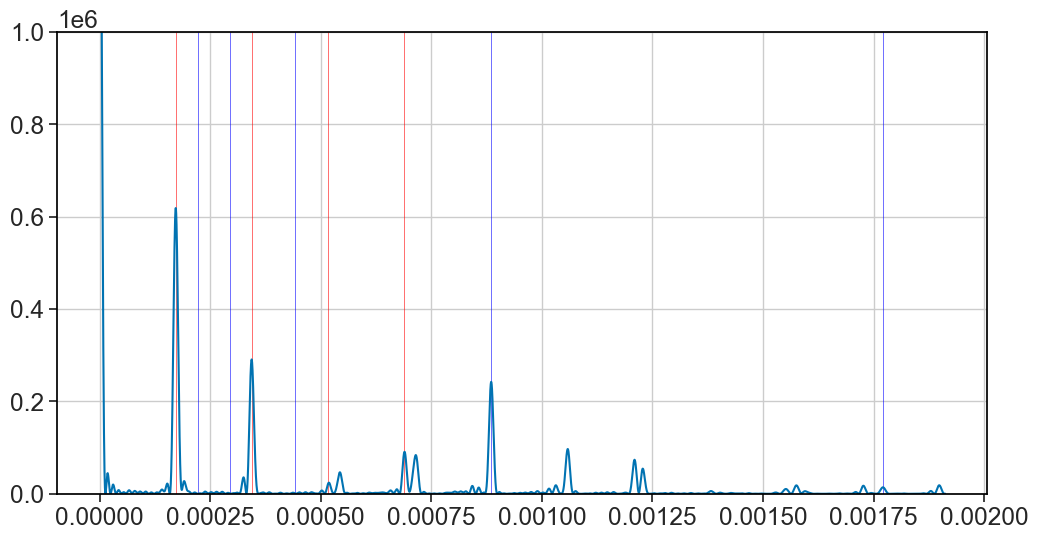

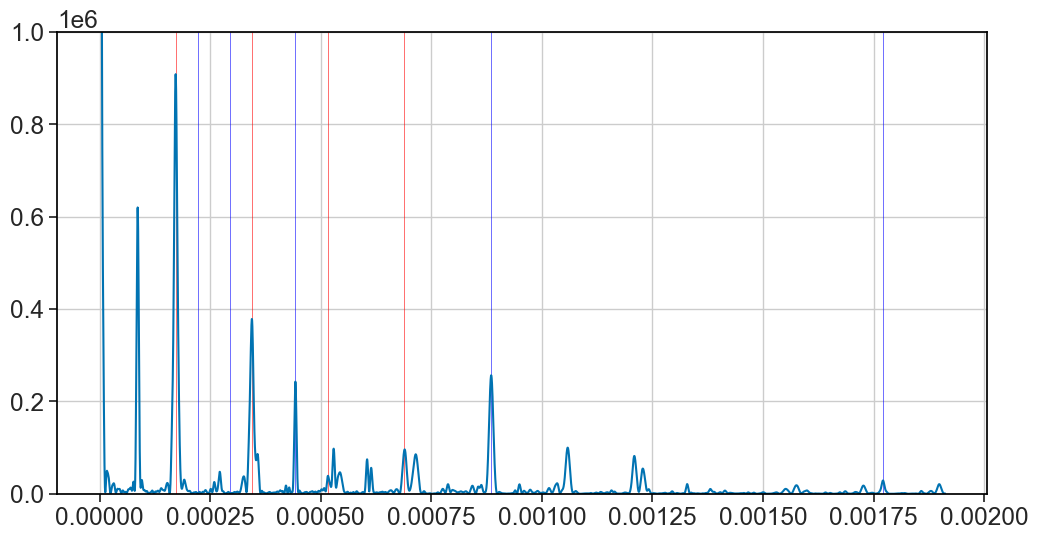

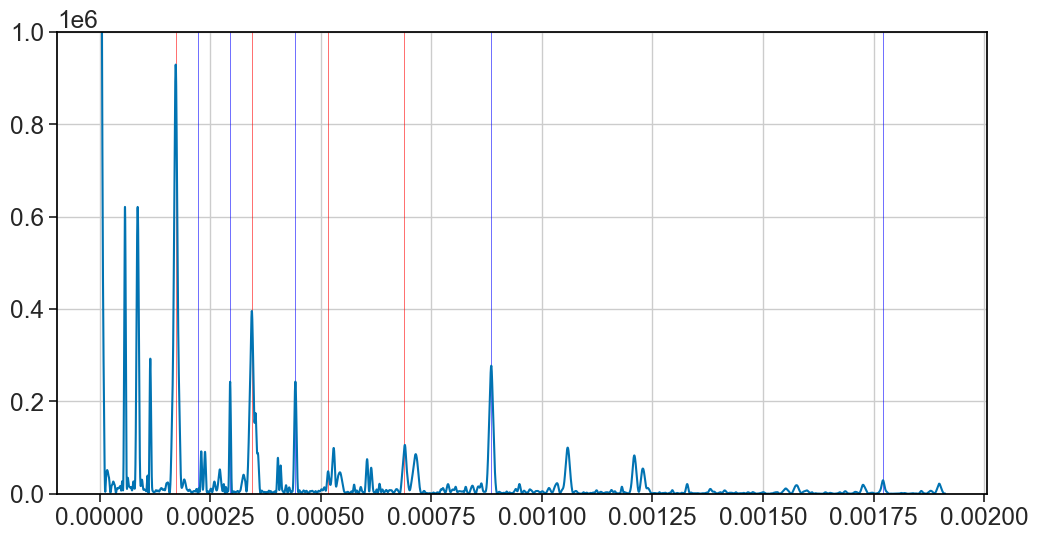

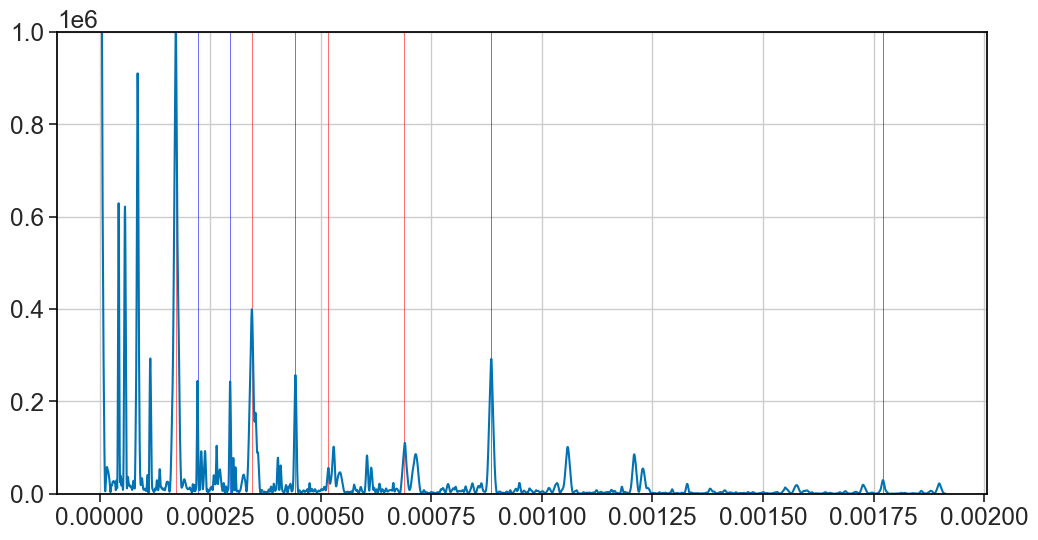

In [38]:
search_freqs = np.linspace(fad_pds.freq[0] - (fad_pds.df), fad_pds.freq[5] + (fad_pds.df/2.), 10000)
fgrid, z_n_stats = z_n_search(all_times, frequencies=search_freqs, nharm=1)

print(search_freqs)

plt.figure(figsize=(12,6))
plt.axvline(1/(96.8*60), lw=0.4, color='red')
plt.axvline(2/(96.8*60), lw=0.4, color='red')
plt.axvline(3/(96.8*60), lw=0.4, color='red')
plt.axvline(4/(96.8*60), lw=0.4, color='red')

plt.axvline(0.0008857, lw=0.4, color='blue')
plt.axvline(0.0008857/2, lw=0.4, color='blue')
plt.axvline(0.0008857/3, lw=0.4, color='blue')
plt.axvline(0.0008857/4, lw=0.4, color='blue')
plt.axvline(0.0008857*2, lw=0.4, color='blue')

plt.ylim(0.,1000000)

plt.plot(fgrid, z_n_stats)

search_freqs = np.linspace(fad_pds.freq[0] - (fad_pds.df), fad_pds.freq[5] + (fad_pds.df/2.), 10000)
fgrid, z_n_stats = z_n_search(all_times, frequencies=search_freqs, nharm=2)

print(search_freqs)

plt.figure(figsize=(12,6))
plt.axvline(1/(96.8*60), lw=0.4, color='red')
plt.axvline(2/(96.8*60), lw=0.4, color='red')
plt.axvline(3/(96.8*60), lw=0.4, color='red')
plt.axvline(4/(96.8*60), lw=0.4, color='red')

plt.axvline(0.0008857, lw=0.4, color='blue')
plt.axvline(0.0008857/2, lw=0.4, color='blue')
plt.axvline(0.0008857/3, lw=0.4, color='blue')
plt.axvline(0.0008857/4, lw=0.4, color='blue')
plt.axvline(0.0008857*2, lw=0.4, color='blue')

plt.ylim(0.,1000000)

plt.plot(fgrid, z_n_stats)

search_freqs = np.linspace(fad_pds.freq[0] - (fad_pds.df), fad_pds.freq[5] + (fad_pds.df/2.), 10000)
fgrid, z_n_stats = z_n_search(all_times, frequencies=search_freqs, nharm=3)

print(search_freqs)

plt.figure(figsize=(12,6))
plt.axvline(1/(96.8*60), lw=0.4, color='red')
plt.axvline(2/(96.8*60), lw=0.4, color='red')
plt.axvline(3/(96.8*60), lw=0.4, color='red')
plt.axvline(4/(96.8*60), lw=0.4, color='red')

plt.axvline(0.0008857, lw=0.4, color='blue')
plt.axvline(0.0008857/2, lw=0.4, color='blue')
plt.axvline(0.0008857/3, lw=0.4, color='blue')
plt.axvline(0.0008857/4, lw=0.4, color='blue')
plt.axvline(0.0008857*2, lw=0.4, color='blue')

plt.ylim(0.,1000000)

plt.plot(fgrid, z_n_stats)

search_freqs = np.linspace(fad_pds.freq[0] - (fad_pds.df), fad_pds.freq[5] + (fad_pds.df/2.), 10000)
fgrid, z_n_stats = z_n_search(all_times, frequencies=search_freqs, nharm=4)

print(search_freqs)

plt.figure(figsize=(12,6))
plt.axvline(1/(96.8*60), lw=0.4, color='red')
plt.axvline(2/(96.8*60), lw=0.4, color='red')
plt.axvline(3/(96.8*60), lw=0.4, color='red')
plt.axvline(4/(96.8*60), lw=0.4, color='red')

plt.axvline(0.0008857, lw=0.4, color='blue')
plt.axvline(0.0008857/2, lw=0.4, color='blue')
plt.axvline(0.0008857/3, lw=0.4, color='blue')
plt.axvline(0.0008857/4, lw=0.4, color='blue')
plt.axvline(0.0008857*2, lw=0.4, color='blue')

plt.ylim(0.,1000000)

plt.plot(fgrid, z_n_stats)


# plt.figure()
# phase_bins, profile, profile_err = fold_events(all_times, [popt[1]], nbin=128)
# plt.errorbar(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), yerr=np.concatenate([profile_err, profile_err])/np.mean(profile), fmt='', ls='', color='C0')
# plt.step(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), where='mid', color='C0')
# plt.ylabel('Normalized counts')
# plt.xlabel('Pulse Phase')
# plt.xlim(0.,2.)
# plt.tight_layout()
# # plt.savefig(plot_dir + OBSID + '_pulseprofile_4harm.pdf')

# print(str(PF(profile)*100) + ' +/- ' + str(PF_err(profile, profile_err)*100))
# print(str(1/popt[1]) + ' +\- ' + str(1.64485*np.sqrt(np.diag(pcov))[1]/(popt[1]*popt[1])))
# print(str(1/popt[1]) + ' +\- ' + str(1.64485*popt[2]/(popt[1]*popt[1])))
# print(str(popt[1]) + ' +\- ' + str(np.sqrt(np.diag(pcov))[1]))

In [ ]:
search_freqs = np.linspace(fad_pds.freq[0] - (fad_pds.df/2.), fad_pds.freq[1] + (fad_pds.df/2.), 1000)
fgrid, z_n_stats = z_n_search(all_times, frequencies=search_freqs, nharm=4)

# print(search_freqs)

fit_mask = (fgrid < 0.0008875) * (fgrid > 0.000884)
# fit_mask = (fgrid < 0.000892) * (fgrid > 0.00088)
popt, pcov = curve_fit(gaussian,fgrid[fit_mask],z_n_stats[fit_mask],p0=[20000, 0.00090,0.00003])

spline = CubicSpline(fgrid, z_n_stats)
roots = spline.derivative().roots()
nu_tot = roots[(0.000884 < roots) * (roots<0.0008875)]
print(nu_tot)
roots = CubicSpline(fgrid, z_n_stats - spline(nu_tot) + 13.3616).roots()
nu_tot_err = roots[(0.000884 < roots) * (roots<0.0008875)] - nu_tot
print(nu_tot_err)

plt.figure()
plt.plot(fgrid[fit_mask], z_n_stats[fit_mask])
plt.plot(fgrid[fit_mask], spline(fgrid[fit_mask]))
plt.axvline(nu_tot)

spline = CubicSpline(np.flip(1/fgrid), np.flip(z_n_stats))
roots = spline.derivative().roots()
p_tot = roots[(1/0.000884 > roots) * (roots>1/0.0008875)]
print(p_tot)
roots = CubicSpline(np.sort(1/fgrid), (np.flip(z_n_stats) - spline(p_tot) + 13.3616)).roots()
p_tot_err = roots[(1/0.000884 > roots) * (roots>1/0.0008875)] - p_tot
print(p_tot_err)

plt.figure()
phase_bins, profile, profile_err = fold_events(all_times, [popt[1]], nbin=128)
plt.errorbar(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), yerr=np.concatenate([profile_err, profile_err])/np.mean(profile), fmt='', ls='', color='C0')
plt.step(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), where='mid', color='C0')
plt.ylabel('Normalized counts')
plt.xlabel('Pulse Phase')
plt.xlim(0.,2.)
plt.tight_layout()
# plt.savefig(plot_dir + OBSID + '_pulseprofile_4harm.pdf')

print(str(PF(profile)*100) + ' +/- ' + str(PF_err(profile, profile_err)*100))
# print(str(1/popt[1]) + ' +\- ' + str(1.64485*np.sqrt(np.diag(pcov))[1]/(popt[1]*popt[1])))
# print(str(1/popt[1]) + ' +\- ' + str(1.64485*popt[2]/(popt[1]*popt[1])))
# print(str(popt[1]) + ' +\- ' + str(np.sqrt(np.diag(pcov))[1]))

[]


ValueError: operands could not be broadcast together with shapes (1000,) (0,) 

[0.0008857]
[-7.37612367e-08  6.90536414e-08]
[1129.05011577]
[-0.08802761  0.09403436]
82.40354535974974 +/- 0.6468073223294049


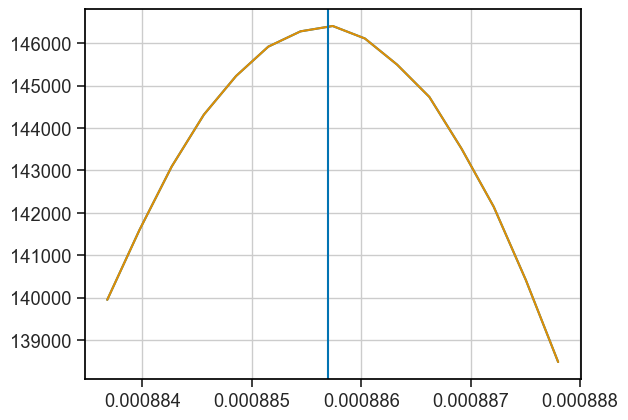

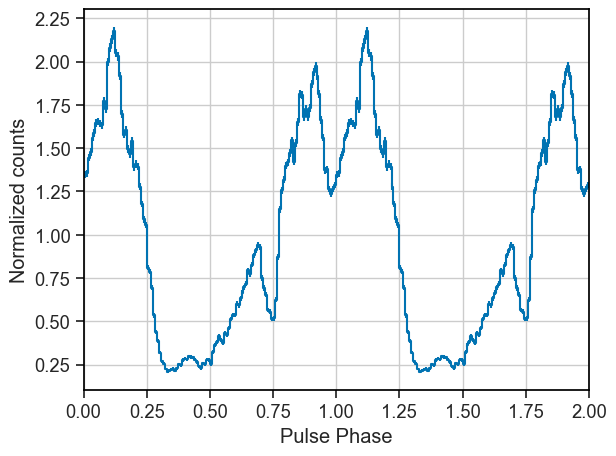

In [158]:
search_freqs = np.linspace(fad_pds.freq[2] - (fad_pds.df/2.), fad_pds.freq[2] + (fad_pds.df/2.), 10000)
fgrid, z_n_stats = z_n_search(half_times_1, frequencies=search_freqs, nharm=4)

# print(search_freqs)

fit_mask = (fgrid < 0.000888) * (fgrid > 0.0008835)
# fit_mask = (fgrid < 0.000892) * (fgrid > 0.00088)
# popt, pcov = curve_fit(gaussian,fgrid[fit_mask],z_n_stats[fit_mask],p0=[20000, 0.00090,0.00003])

spline = CubicSpline(fgrid, z_n_stats)
roots = spline.derivative().roots()
nu_1 = roots[(0.000884 < roots) * (roots<0.0008875)]
print(nu_1)
roots = CubicSpline(fgrid, z_n_stats - spline(nu_1) + 13.3616).roots()
nu_1_err = roots[(0.000884 < roots) * (roots<0.0008875)] - nu_1
print(nu_1_err)

plt.figure()
plt.plot(fgrid[fit_mask], z_n_stats[fit_mask])
plt.plot(fgrid[fit_mask], spline(fgrid[fit_mask]))
plt.axvline(nu_1)

spline = CubicSpline(np.flip(1/fgrid), np.flip(z_n_stats))
roots = spline.derivative().roots()
p_1 = roots[(1/0.000884 > roots) * (roots>1/0.0008875)]
print(p_1)
roots = CubicSpline(np.sort(1/fgrid), (np.flip(z_n_stats) - spline(p_1) + 13.3616)).roots()
p_1_err = roots[(1/0.000884 > roots) * (roots>1/0.0008875)] - p_1
print(p_1_err)

plt.figure()
phase_bins, profile, profile_err = fold_events(half_times_1, nu_1, nbin=128)
plt.errorbar(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), yerr=np.concatenate([profile_err, profile_err])/np.mean(profile), fmt='', ls='', color='C0')
plt.step(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), where='mid', color='C0')
plt.ylabel('Normalized counts')
plt.xlabel('Pulse Phase')
plt.xlim(0.,2.)
plt.tight_layout()
# plt.savefig(plot_dir + OBSID + '_pulseprofile_4harm.pdf')

print(str(PF(profile)*100) + ' +/- ' + str(PF_err(profile, profile_err)*100))
# print(str(1/popt[1]) + ' +\- ' + str(np.sqrt(np.diag(pcov))[1]/(popt[1]*popt[1])))
# print(str(1/popt[1]) + ' +\- ' + str(popt[2]/(popt[1]*popt[1])))
# print(str(popt[1]) + ' +\- ' + str(np.sqrt(np.diag(pcov))[1]))

[0.00088624]
[-8.25202836e-08  8.53762767e-08]
[1128.36250686]
[-0.10870304  0.10508449]
83.81853469189714 +/- 0.6006681184424976


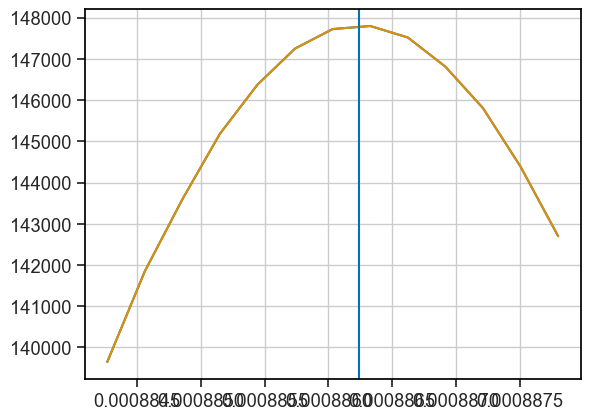

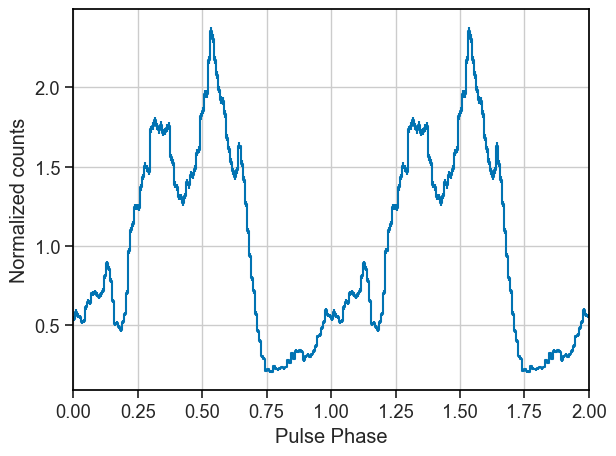

In [159]:
search_freqs = np.linspace(fad_pds.freq[2] - (fad_pds.df/2.), fad_pds.freq[2] + (fad_pds.df/2.), 1000)
fgrid, z_n_stats = z_n_search(half_times_2, frequencies=search_freqs, nharm=4)

# print(search_freqs)

fit_mask = (fgrid < 0.000888) * (fgrid > 0.000884)
# fit_mask = (fgrid < 0.000892) * (fgrid > 0.00088)
popt, pcov = curve_fit(gaussian,fgrid[fit_mask],z_n_stats[fit_mask],p0=[20000, 0.00090,0.00003])

spline = CubicSpline(fgrid, z_n_stats)
roots = spline.derivative().roots()
nu_2 = roots[(0.000884 < roots) * (roots<0.0008875)]
print(nu_2)
roots = CubicSpline(fgrid, z_n_stats - spline(nu_2) + 13.3616).roots()
nu_2_err = roots[(0.000884 < roots) * (roots<0.0008875)] - nu_2
print(nu_2_err)

plt.figure()
plt.plot(fgrid[fit_mask], z_n_stats[fit_mask])
plt.plot(fgrid[fit_mask], spline(fgrid[fit_mask]))
plt.axvline(nu_2)

spline = CubicSpline(np.flip(1/fgrid), np.flip(z_n_stats))
roots = spline.derivative().roots()
p_2 = roots[(1/0.000884 > roots) * (roots>1/0.0008875)]
print(p_2)
roots = CubicSpline(np.sort(1/fgrid), (np.flip(z_n_stats) - spline(p_2) + 13.3616)).roots()
p_2_err = roots[(1/0.000884 > roots) * (roots>1/0.0008875)] - p_2
print(p_2_err)

plt.figure()
phase_bins, profile, profile_err = fold_events(half_times_2, nu_2, nbin=128)
plt.errorbar(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), yerr=np.concatenate([profile_err, profile_err])/np.mean(profile), fmt='', ls='', color='C0')
plt.step(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), where='mid', color='C0')
plt.ylabel('Normalized counts')
plt.xlabel('Pulse Phase')
plt.xlim(0.,2.)
plt.tight_layout()
# plt.savefig(plot_dir + OBSID + '_pulseprofile_4harm.pdf')

print(str(PF(profile)*100) + ' +/- ' + str(PF_err(profile, profile_err)*100))
# print(str(1/popt[1]) + ' +\- ' + str(np.sqrt(np.diag(pcov))[1]/(popt[1]*popt[1])))
# print(str(1/popt[1]) + ' +\- ' + str(popt[2]/(popt[1]*popt[1])))
# print(str(popt[1]) + ' +\- ' + str(np.sqrt(np.diag(pcov))[1]))
# nu_2 = popt[1]
# nuerr_2 = np.sqrt(np.diag(pcov))[1]
# p_2 = 1/popt[1]
# perr_2 = np.sqrt(np.diag(pcov))[1]/(popt[1]*popt[1])

1129.7556184899036 +/- [-0.09778759  0.09743611]
1128.7758413377396 +/- [-0.10843069  0.10155985]
2.0015150589038708e-11


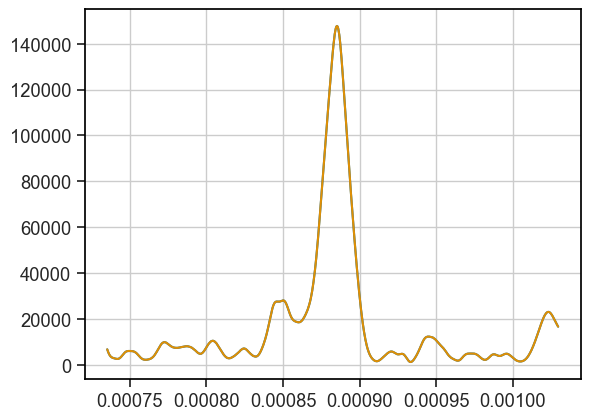

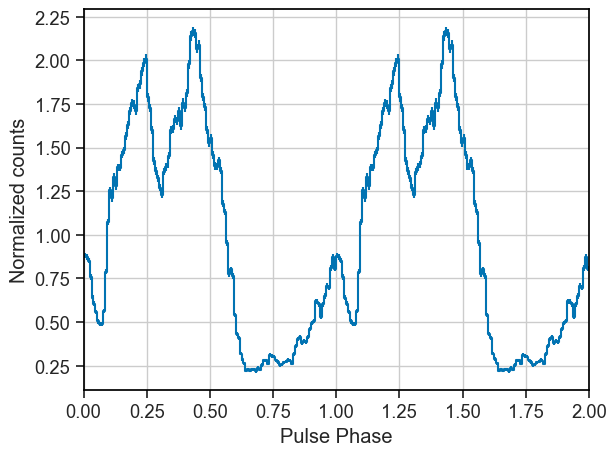

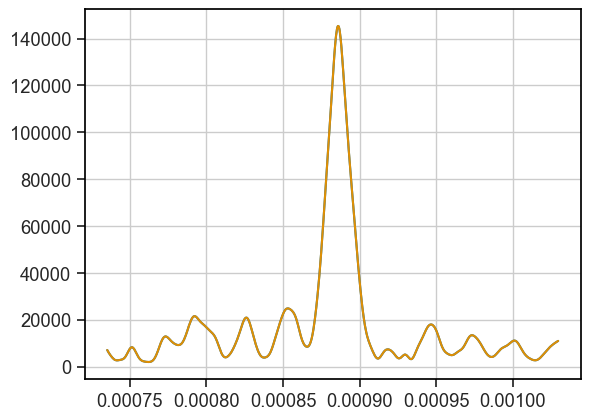

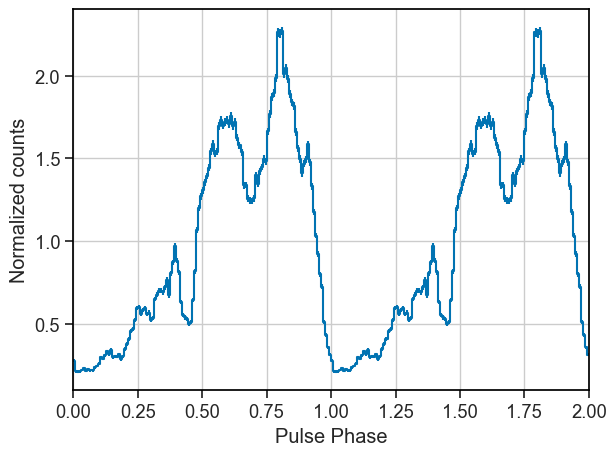

In [169]:
nus = []
nuerrs = []
ps = []
perrs = []
meantimes = []
n_ints = 2
int_len = (np.max(all_times)-np.min(all_times))/n_ints
for i in range(n_ints):
    temp_mask = ((i*int_len) < (all_times-np.min(all_times))) * ((all_times-np.min(all_times)) <= ((i+1)*int_len))
    temp_times = all_times[temp_mask]
    meantimes.append(np.mean(temp_times))
    search_freqs = np.linspace(fad_pds.freq[2] - (fad_pds.df/2.), fad_pds.freq[2] + (fad_pds.df/2.), 1000)
    fgrid, z_n_stats = z_n_search(temp_times, frequencies=search_freqs, nharm=4)

    fit_mask = (fgrid < 0.000888) * (fgrid > 0.000880)
    
    spline = CubicSpline(fgrid, z_n_stats)
    plt.figure()
    plt.plot(fgrid, z_n_stats)
    plt.plot(fgrid, spline(fgrid))
    # plt.axvline(nu)

    roots = spline.derivative().roots()
    nu = roots[np.argmax(spline(roots))]
    nus.append(nu)
    roots = CubicSpline(fgrid, z_n_stats - spline(nu) + 13.3616).roots()
    nuerr = roots[(0.000880 < roots) * (roots<0.0008875)] - nu
    nuerrs.append(nuerr)

    spline = CubicSpline(np.flip(1/fgrid), np.flip(z_n_stats))
    roots = spline.derivative().roots()
    p = roots[np.argmax(spline(roots))]
    roots = CubicSpline(np.sort(1/fgrid), (np.flip(z_n_stats) - spline(p) + 13.3616)).roots()
    perr = roots[(1/0.000880 > roots) * (roots>1/0.0008875)] - p
    perrs.append(perr)
    print(p, '+/-', perr)

    plt.figure()
    phase_bins, profile, profile_err = fold_events(temp_times, nu, nbin=128)
    plt.errorbar(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), yerr=np.concatenate([profile_err, profile_err])/np.mean(profile), fmt='', ls='', color='C0')
    plt.step(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), where='mid', color='C0')
    plt.ylabel('Normalized counts')
    plt.xlabel('Pulse Phase')
    plt.xlim(0.,2.)
    plt.tight_layout()
    # plt.savefig(plot_dir + OBSID + '_pulseprofile_4harm.pdf')

print((nus[-1]-nus[0])/(meantimes[-1] - meantimes[0]))

In [160]:
nu_dot = (nu_2 - nu_1)/(np.mean(half_times_2) - np.mean(half_times_1))
nu_dot_err = np.sqrt(np.square(nu_1_err) + np.square(nu_2_err))/(np.mean(half_times_2) - np.mean(half_times_1))
print(str(nu_dot), ' +/- ', str(nu_dot_err))
p_dot = (p_2 - p_1)/(np.mean(half_times_2) - np.mean(half_times_1))
p_dot_err = np.sqrt(np.square(p_1_err) + np.square(p_2_err))/(np.mean(half_times_2) - np.mean(half_times_1))
print(str(p_dot), ' +/- ', str(p_dot_err))

[1.40845195e-11]  +/-  [2.88841489e-12 2.86559490e-12]
[-1.79443364e-05]  +/-  [3.65029668e-06 3.68002700e-06]


82.80943646828158 +/- 0.4458252815099172
81.47086914995224 +/- 0.5973603437077798
84.7936041768641 +/- 0.6771140147132384
89.01098901098901 +/- 2.758300052001288


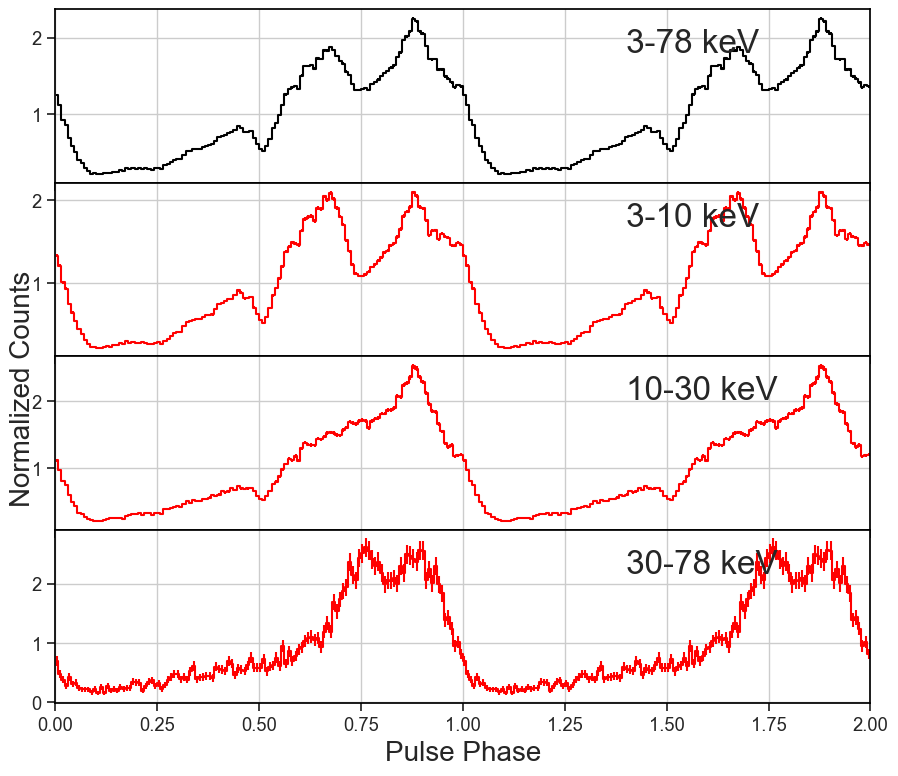

In [121]:
energy_bins = [[3,78], [3,10], [10,30], [30,78]]

fig, axes = plt.subplots(len(energy_bins), 1, figsize = (9, 2*len(energy_bins)), gridspec_kw={'hspace':0}, sharex=True)

for i in range(len(energy_bins)):
    e=energy_bins[i]
    color='red'
    if i==0:
        color='black'
    energy_mask_A = (events[0].pi >= eV_to_PI(1000*e[0])) * (events[0].pi < eV_to_PI(1000*e[1]))
    energy_mask_B = (events[1].pi >= eV_to_PI(1000*e[0])) * (events[1].pi < eV_to_PI(1000*e[1]))
    temp_times = np.sort(np.concatenate([events[0].time[energy_mask_A], events[1].time[energy_mask_B]]))
    
    phase_bins, profile, profile_err = fold_events(temp_times, nu_tot, nu_dot, nbin=128, ref_time = np.min(all_times))
    axes[i].errorbar(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), yerr=np.concatenate([profile_err, profile_err])/np.mean(profile), fmt='', ls='', color=color)
    axes[i].step(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), where='mid', color=color)
    axes[i].text(0.7, 0.75, str(e[0]) + '-' + str(e[1]) + ' keV', transform=axes[i].transAxes, fontsize=24)
    
    print(str(PF(profile)*100) + ' +/- ' + str(PF_err(profile, profile_err)*100))

fig.text(0.0, 0.5, 'Normalized Counts', va='center', rotation='vertical', fontsize=20)
axes[-1].set_xlabel('Pulse Phase', fontsize=20)
axes[-1].set_xlim(0.,2.)
plt.tight_layout()
# plt.savefig(plot_dir + OBSID + '_pulseprofile_4harm_Esplit.pdf')

81.90657644044413 +/- 0.46501073849233976
81.22186495176848 +/- 0.6039357033128434
84.07859078590786 +/- 0.7045620037416904
89.72602739726028 +/- 2.5836949273783487


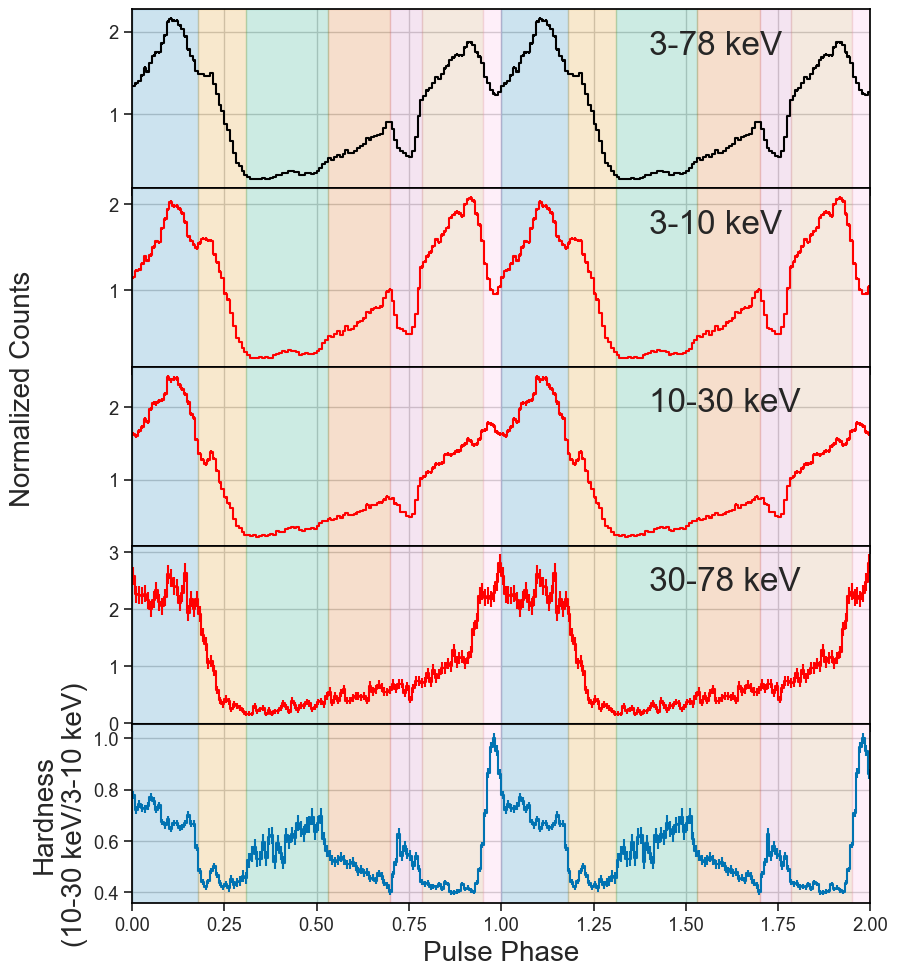

In [43]:
energy_bins = [[3,78], [3,10], [10,30], [30,78]]

fig, axes = plt.subplots(len(energy_bins)+1, 1, figsize = (9, 2*(len(energy_bins)+1)), gridspec_kw={'hspace':0}, sharex=True)

for i in range(len(energy_bins)):
    e=energy_bins[i]
    color='red'
    if i==0:
        color='black'
    energy_mask_A = (events[0].pi >= eV_to_PI(1000*e[0])) * (events[0].pi < eV_to_PI(1000*e[1]))
    energy_mask_B = (events[1].pi >= eV_to_PI(1000*e[0])) * (events[1].pi < eV_to_PI(1000*e[1]))
    temp_times = np.sort(np.concatenate([events[0].time[energy_mask_A], events[1].time[energy_mask_B]]))
    
    phase_bins, profile, profile_err = fold_events(temp_times, 0.0008856113733277114, nbin=128)
    axes[i].errorbar(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), yerr=np.concatenate([profile_err, profile_err])/np.mean(profile), fmt='', ls='', color=color)
    axes[i].step(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), where='mid', color=color)
    axes[i].text(0.7, 0.75, str(e[0]) + '-' + str(e[1]) + ' keV', transform=axes[i].transAxes, fontsize=24)
    
    print(str(PF(profile)*100) + ' +/- ' + str(PF_err(profile, profile_err)*100))

energy_mask_A_low = (events[0].pi >= eV_to_PI(1000*3.0)) * (events[0].pi < eV_to_PI(1000*10.0))
energy_mask_B_low = (events[1].pi >= eV_to_PI(1000*3.0)) * (events[1].pi < eV_to_PI(1000*10.0))

energy_mask_A_high = (events[0].pi >= eV_to_PI(1000*10.0)) * (events[0].pi < eV_to_PI(1000*30.0))
energy_mask_B_high = (events[1].pi >= eV_to_PI(1000*10.0)) * (events[1].pi < eV_to_PI(1000*30.0))

times_low = np.sort(np.concatenate([events[0].time[energy_mask_A_low], events[1].time[energy_mask_B_low]]))
times_high = np.sort(np.concatenate([events[0].time[energy_mask_A_high], events[1].time[energy_mask_B_high]]))

phase_bins_high, profile_high, profile_err_high = fold_events(times_high, 0.0008856113733277114, nbin=128)
phase_bins_low, profile_low, profile_err_low = fold_events(times_low, 0.0008856113733277114, nbin=128)
hardness_profile =  profile_high/profile_low
hardness_profile_err =  hardness_profile*np.sqrt(np.square(profile_err_high/profile_high) + np.square(profile_err_low/profile_low))
axes[-1].errorbar(np.concatenate([phase_bins_low, phase_bins_low+1]), np.concatenate([hardness_profile,hardness_profile]), \
                 yerr=np.concatenate([hardness_profile_err,hardness_profile_err]), fmt='', ls='', color='C0')
axes[-1].step(np.concatenate([phase_bins_low, phase_bins_low+1]), np.concatenate([hardness_profile,hardness_profile]), where='mid', color='C0')
    
    
fig.text(0.0, 0.6, 'Normalized Counts', va='center', rotation='vertical', fontsize=20)
axes[-1].set_xlabel('Pulse Phase', fontsize=20)
axes[-1].set_ylabel('Hardness\n(10-30 keV/3-10 keV)', fontsize=20)
axes[-1].set_xlim(0.,2.)
phase_bin_edges = [0.0,0.18,0.31,0.53,0.7,0.785, 0.95, 1.0]
for ax in axes:
    for i in range(len(phase_bin_edges)-1):
        ax.axvspan(phase_bin_edges[i],phase_bin_edges[i+1], alpha=0.2, color='C' + str(i))
        ax.axvspan(phase_bin_edges[i]+1.0,phase_bin_edges[i+1]+1.0, alpha=0.2, color='C' + str(i))
plt.tight_layout()
# plt.savefig(plot_dir + OBSID + '_pulseprofile_4harm_Esplit_hardness.pdf')

phase_bin_edges = [0.0,0.18,0.31,0.53,0.7,0.785, 0.95, 1.0]

In [41]:
n_pulses = int(np.ceil((np.max(all_times)-np.min(all_times))*nu))
# print(n_pulses)
pulse_gtis = []
for i in range(len(phase_bin_edges)-1):
    gti_starts = np.min(all_times)+np.array([(j + phase_bin_edges[i])/nu for j in range(n_pulses)])
    gti_stops = np.min(all_times)+np.array([(j + phase_bin_edges[i+1])/nu for j in range(n_pulses)])
    pulse_gtis.append(np.array([gti_starts, gti_stops]).T)
print(len(pulse_gtis))

7


NameError: name 'pulse_on_crossed' is not defined

# Record pulse profile throughout outburst

In [87]:
nustar_obs1 = [5.975194215490741E+04, 5.975194215490741E+04 + (8.186399999976158E+04/(3600*24))]
# obs1_freq = [0.0008852178554669009, 6.514833401702306e-09] # nharm = 1
obs1_freq = [0.0008856113733277114, 3.2805179578745355e-08] # nharm = 4
nustar_obs2 = [5.980585043905106E+04, 5.980585043905106E+04 + (4.208824998831749E+04/(3600*24))]
# obs2_freq = [0.0008976535039138576, 5.5580782526046156e-08] # nharm = 1
obs2_freq = [0.0009235725465767321, 3.8900667499038016e-07] # nharm = 4

nustar_times = np.array([(nustar_obs1[1]+nustar_obs1[0])/2, (nustar_obs2[1]+nustar_obs2[0])/2])
nustar_time_err = np.array([(nustar_obs1[1]-nustar_obs1[0])/2, (nustar_obs2[1]-nustar_obs2[0])/2])
nustar_freqs = np.array([obs1_freq[0], obs2_freq[0]])
nustar_freq_err = np.array([obs1_freq[1], obs2_freq[1]])

gbm_data = fits.open(root_dir + 'GBM/maxij0655_old.fits')
pulse_data = gbm_data[2].data
mask = pulse_data['FREQUENCY'] != 0
# print((pulse_data['FREQUENCY'][mask][1]-pulse_data['FREQUENCY'][mask][0])/((pulse_data['TSTART'][mask][1]-pulse_data['TSTART'][mask][0])*3600*24))
# print(((1/pulse_data['FREQUENCY'][mask][1])-(1/pulse_data['FREQUENCY'][mask][0]))/((pulse_data['TSTART'][mask][1]-pulse_data['TSTART'][mask][0])*3600*24))


temp_mjd_gbm_nustar = np.concatenate([pulse_data['PSRTIME'][mask], nustar_times])
mjd_gbm_nustar = temp_mjd_gbm_nustar[np.argsort(temp_mjd_gbm_nustar)]
f_gbm_nustar = np.concatenate([pulse_data['FREQUENCY'][mask], nustar_freqs])[np.argsort(temp_mjd_gbm_nustar)]
ferr_gbm_nustar = np.concatenate([pulse_data['FREQUENCY_ERR'][mask], nustar_freq_err])[np.argsort(temp_mjd_gbm_nustar)]

fdot_mjd = (mjd_gbm_nustar[1:] + mjd_gbm_nustar[:-1])/2
fdot_mjd_err = (mjd_gbm_nustar[1:] - mjd_gbm_nustar[:-1])/2
fdot_mHzperday = 1000.*(f_gbm_nustar[1:] - f_gbm_nustar[:-1])/(mjd_gbm_nustar[1:] - mjd_gbm_nustar[:-1])
fdot_mHzperday_err = 1000.*np.sqrt(np.square(ferr_gbm_nustar[1:]) + np.square(ferr_gbm_nustar[:-1]))/(mjd_gbm_nustar[1:] - mjd_gbm_nustar[:-1])



[0.5038386  0.50809657 0.51235455 ... 0.29184744 0.29629224 0.30073703]


(59751.0, 59752.0)

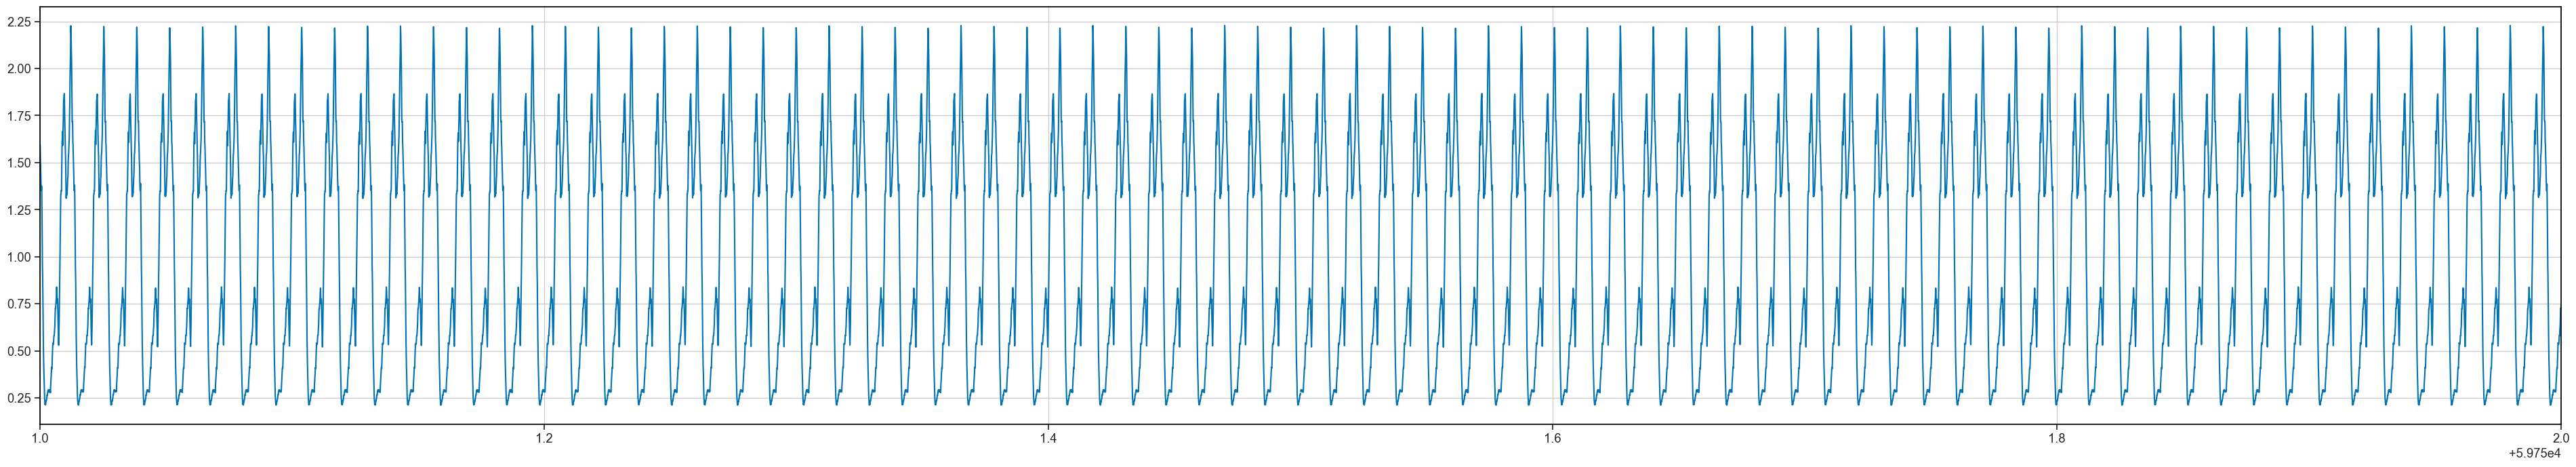

In [113]:
energy_mask_A = (events[0].pi >= eV_to_PI(1000*3.)) * (events[0].pi <= eV_to_PI(1000*78.))
energy_mask_B = (events[1].pi >= eV_to_PI(1000*3.)) * (events[1].pi <= eV_to_PI(1000*78.))

phase_bins, profile, profile_err = fold_events(all_times, nu_1, nu_dot, nbin=128, ref_time = np.min(all_times))
profile_interp = interp1d(np.concatenate([[phase_bins[-1]-1], phase_bins, [phase_bins[0]+1]]), np.concatenate([[profile[-1]], profile, [profile[0]]])/np.mean(profile), kind='linear')

MJD = np.linspace(np.min(mjd_gbm_nustar), np.max(mjd_gbm_nustar), 1000000)
dphase = f_interp(MJD)*(MJD[1]-MJD[0])*3600*24
phases = np.cumsum(dphase)
phases = phases - interp1d(MJD, phases, kind='linear')(5.975194215490741E+04)
phases = phases - np.floor(phases)
# print(MJD)
print(phases)
extended_profile = profile_interp(phases)
plt.figure(figsize=(48,8))
plt.plot(MJD, extended_profile)
plt.xlim(59751, 59752)
# ascii.write(np.array([MJD, extended_profile]).T, root_dir + 'pulse_history.txt', delimiter= ',', names=['MJD', 'PROFILE'], overwrite=True)
